In [1]:
import preprocessing as pp
import detection

import os
import matplotlib.pyplot as plt

# 1. Define version of get_edges() to use

In [2]:
f_get_edges = pp.get_edges

# 2. Specify, load, & display test images to use

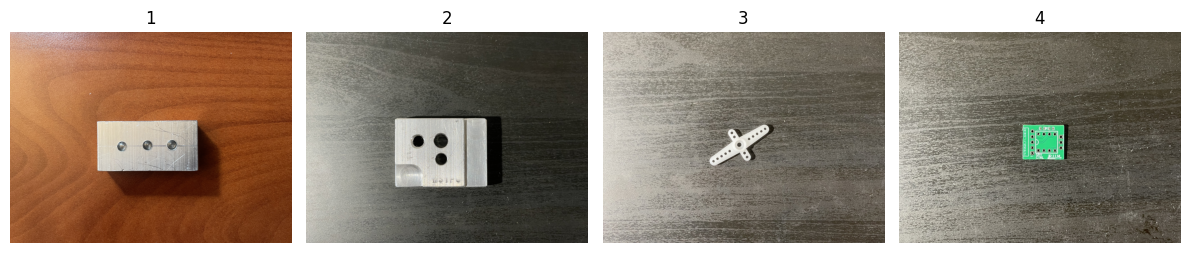

In [3]:
base_path = os.getcwd()
parts_path = os.path.join(base_path, "data", "physical parts")

img1 = os.path.join(parts_path, "Basic II base part.jpg")
img2 = os.path.join(parts_path, "mill part 2.jpeg")
img3 = os.path.join(parts_path, "servo mount 1.jpeg")
img4 = os.path.join(parts_path, "small PCB 2.jpeg")
files = [img1, img2, img3, img4]
titles = ["1", "2", "3", "4"]

imgs = detection.show_images_from_files(files, titles)

# 3. Pass each image through f_get_edges(); extract result & intermediate images

In [4]:
img_results = []
for img in imgs:
    edges, interms = f_get_edges(img)
    result = [img]
    result.extend(interms)
    result.append(edges)
    img_results.append(result)

# 4. Plot all images in organized format
images (or different objects) listed along rows;
intermediate results of each object listed along columns

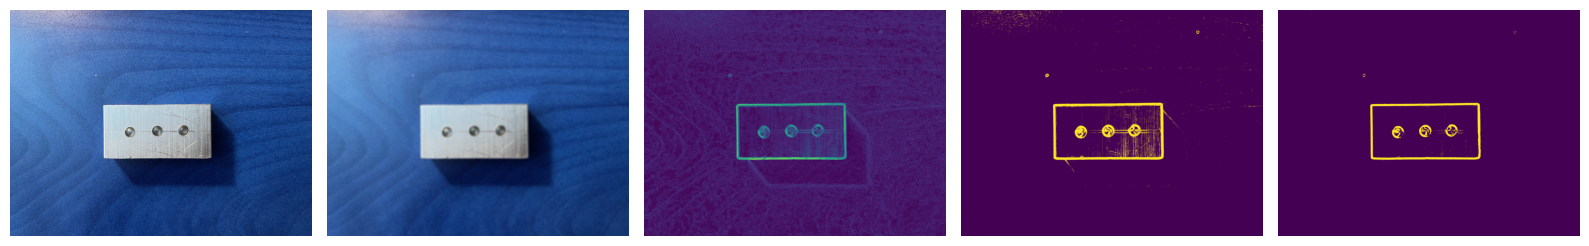

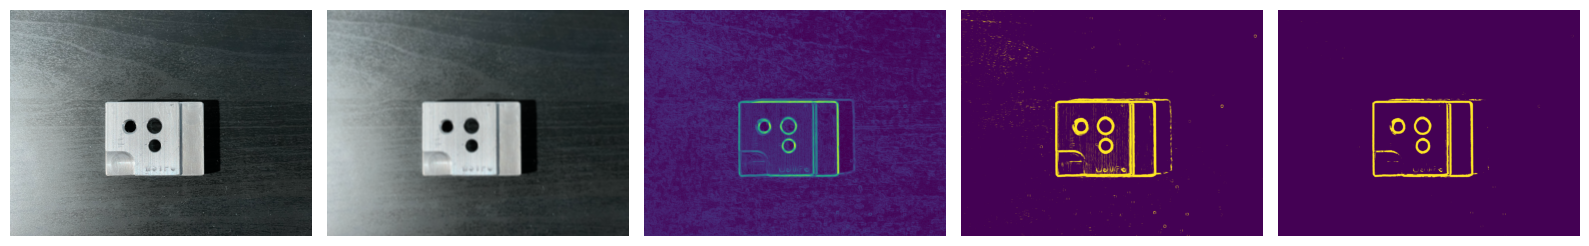

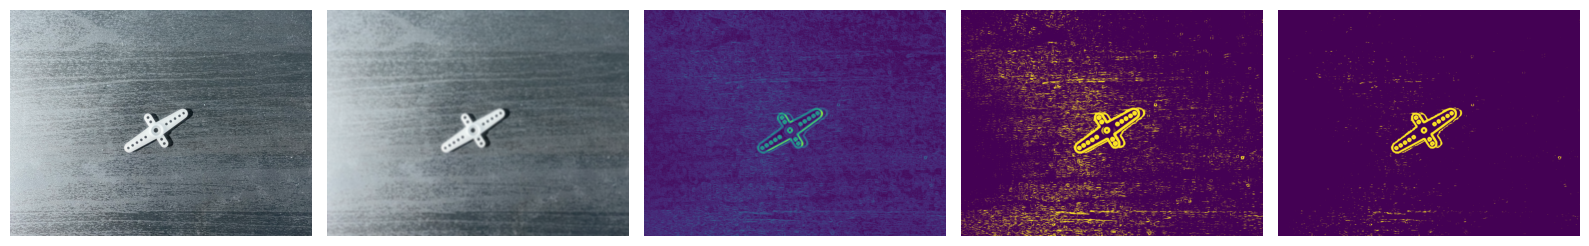

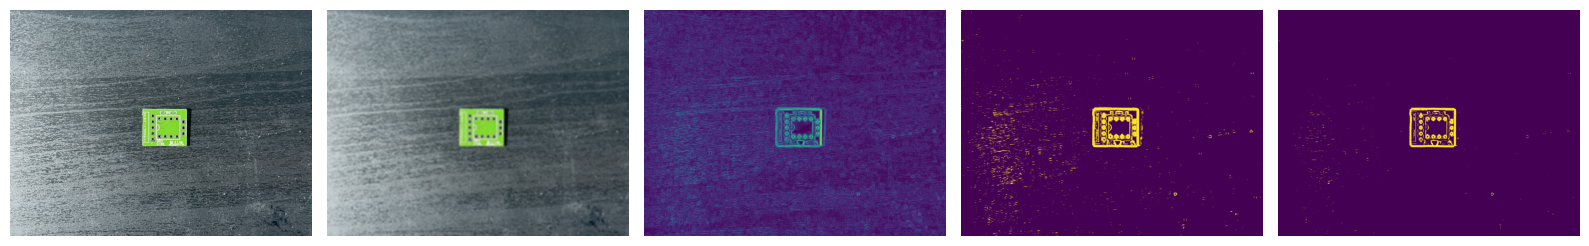

In [9]:
figsize = (16,12)    # physical part images taken from iphone should be of shape 4:3
rows = len(img_results)
cols = len(img_results[0])

for obj in img_results:
    # show rows (objs) one by one in run time
    i = 1
    plt.figure(figsize=figsize)
    for rst in obj:
        plt.subplot(1, cols, i)
        plt.imshow(rst)
        plt.axis('off')
        i += 1
    plt.tight_layout()
    plt.show()
